## Simplified Version of TRAPPIST-1 simulation with only one planet.

#### Sim Setup

In [284]:
import rebound
import reboundx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from copy import deepcopy

# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.random_seed = 13741154 # for reproducibility

# Add the star
sim.add(m=0.09)

# Define planet radii
r_earth = 4.264e-5 # in AU
radii = np.array([1.116, 1.097, 0.788, 0.920, 1.045, 1.129, 0.755]) * r_earth

# Define planet masses
m_earth = 3.003e-6 # in solar masses
masses = np.array([1.374, 1.308, 0.388, 0.692, 1.039, 1.321, 0.326]) * m_earth

masses = masses[0:1] # limits to b
num_planets = len(masses)

planet_names = ['b', 'c', 'd', 'e', 'f', 'g', 'h']

a_b = 0.06 # starting semimajor axis for planet b
P_b = a_b**(3/2)
P0 = np.array([P_b])
a0 = P0**(2/3)
e0 = np.array([0.004])

# Add planets 
for i in range(num_planets):
    sim.add(m=masses[i], a=a0[i], e=e0[i])

# Move to center of momentum
sim.move_to_com()
ps = sim.particles
planets = ps[1:] # for easier indexing

### Sim Params
Based on Huang & Ormel. See `trappist1_migration.ipynb`.

In [285]:
# Free parameters
tau_a_earth = 5e3
C_e = 0.1 
r_c = 0.013
A_a = 100
A_e = 1

# Other parameters
h = 0.03
M_g_dot = 10e-10
M_star = 0.09
gamma_I = 2
tau_d = 1e5
Delta = 2*h*r_c
Q_sim = 100

#### $f_a$, $f_e$ functions
Determines how much damping is done by disk interactions.

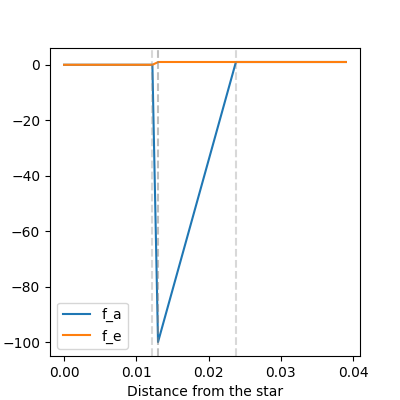

0.01222
0.02378


In [286]:
rebx = reboundx.Extras(sim)

# Planet-disk interaction
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

q_vals = masses / M_star
q_earth =  3.003e-6 / M_star

def f_functions(r):
    # Piecewise functions f_a and f_e
    conditions = [
        r < r_c - Delta,
        (r_c - Delta <= r) & (r < r_c),
        (r_c <= r) & (r < r_c + Delta + 1 / A_a),
        r >= r_c + Delta + 1 / A_a
    ]

    f_a = [
        0,          
        A_a * (r_c - Delta - r) / Delta,
        (r-r_c)* (A_a + 1) / (Delta + 1/A_a) - (A_a), # modified to make it continuous, paper might be wrong
        1
    ]

    f_e = [
        0,          
        A_e * (r - r_c + Delta) / Delta,
        (A_e - 1) * (r_c + Delta + 1 / A_a - r) / (Delta + 1 / A_a) + 1, 
        1
    ]

    f_a_vals = np.select(conditions, f_a, default=np.nan)
    f_e_vals = np.select(conditions, f_e, default=np.nan)
    return f_a_vals, f_e_vals

%matplotlib widget
def plot_f_functions():
    fig, ax = plt.subplots()
    fig.set_figwidth(4.0)
    fig.set_figheight(4.0)

    xs = np.linspace(0, 3*r_c, 1000)
    f_a_vals, f_e_vals = f_functions(xs)
    ax.plot(xs, f_a_vals, label='f_a')  
    ax.plot(xs, f_e_vals, label='f_e')  
    plt.ylabel("$f_a$ or $f_e$")
    plt.xlabel("Distance from the star")
    plt.axvline(r_c-Delta, color='gray', ls='--', alpha=0.3)
    plt.axvline(r_c, color='gray', ls='--', alpha=0.5)
    plt.axvline(r_c+Delta+1/A_a, color='gray', ls='--', alpha=0.3)
    plt.legend()
    plt.show()

plot_f_functions()
print(r_c - Delta)
print(r_c + Delta + 1 / A_a)

#### Tidal damping function 
Computes $\tau_e$ which determines damping due to tidal forces (but this is not used by Huang & Ormel).

In [287]:
# # Tidal damping
# tides = rebx.load_force("tides_constant_time_lag")
# rebx.add_force(tides)

# ps[0].r = 0.0005534056
# ps[0].params['tctl_k2'] = 0.03
# ps[0].params['tctl_tau'] = 0.04

#### Data storage

In [288]:
sim.dt = planets[0].P / 20 # 1/20 of planet b

def get_data_temp(n_out, times):        
    return pd.DataFrame({
        "time": times,
        "a": np.zeros(n_out),
        "e": np.zeros(n_out),
        "tau_a": np.zeros(n_out),
        "tau_e": np.zeros(n_out)
    })

stage1_end = 1000
n_out = 1000
stage1_times = np.linspace(0, stage1_end, n_out)

stage1_data = {name : get_data_temp(n_out, stage1_times) for name in planet_names[:num_planets]}

def stage2():
    # === Stage 2 ===
    # stage2_end = 20
    # stage2_times = np.arange(stage1_end, stage2_end, sim.dt)
    # stage2_steps = len(stage2_times)

    # stage2_data = {name : get_data_temp(stage2_steps, stage2_times) for name in planet_names[:num_planets]}

    # total_data = deepcopy(stage1_data)
    # for name in stage1_data:
    #     total_data[name] = pd.concat(
    #         [stage1_data[name], stage2_data[name]],
    #         axis=0,
    #         ignore_index=True
    #     )

    # display(stage1_data['b'])
    pass

In [ ]:
# Check tau values
def get_taus(p, current_a_vals):
    f_a_vals, f_e_vals = f_functions(current_a_vals)
    current_tau_a = tau_a_earth * (q_earth / q_vals[p]) / f_a_vals[p]
    current_tau_e = C_e * h**2 * current_tau_a * f_a_vals[p] / f_e_vals[p]
    current_tau_e_tidal = 7.63e5 * Q_sim * (masses[p]/m_earth) * (1/M_star)**1.5 * (r_earth/radii[p])** 5 * (planets[p].a/0.05)**6.5
    
    return current_tau_a, current_tau_e, current_tau_e_tidal

p = 0
print(f"tau_a: {get_taus(p)[0]:.2f}")
print(f"tau_e: {get_taus(p)[1]:.2f}")
print(f"tau_e_tidal: {get_taus(p)[2]:.2f}")

tau_a: 3639.01
tau_e: 0.33
tau_e_tidal: 43776524891.26


#### It's time to integrate

In [ ]:
%%time
for i, time in enumerate(stage1_times):  
    sim.integrate(time)      
    current_a_vals = np.array([p.a for p in sim.particles[1:]])
    
    for p in range(num_planets):
        tau_a, tau_e, tau_e_tidal = get_taus(p, current_a_vals)
        planets[p].params["tau_a"] = tau_a
        planets[p].params["tau_e"] = tau_e + tau_e_tidal

        # Record data    
        name = planet_names[p]
        stage1_data[name]["a"][i] = planets[p].a
        stage1_data[name]["e"][i] = planets[p].e
        stage1_data[name]["tau_a"][i] = f_a_vals[p] # temporary for troubleshooting
        stage1_data[name]["tau_e"][i] = tau_e + tau_e_tidal

CPU times: user 180 ms, sys: 2.84 ms, total: 182 ms
Wall time: 182 ms


#### Plot it!

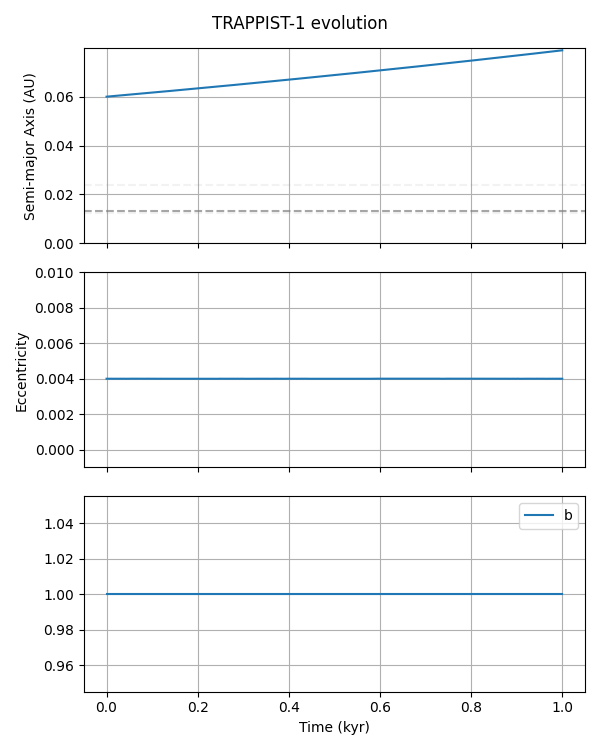

In [291]:
%matplotlib widget

def plot_trappist1():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    fig.set_figwidth(6.0)
    fig.set_figheight(7.5)

    for p in range(num_planets):
        # could also try plotting log
        name = planet_names[p]
        ax1.plot(stage1_times/1000, stage1_data[name]["a"], label=name) 
        ax2.plot(stage1_times/1000, stage1_data[name]["e"], label=name)
        ax3.plot(stage1_times/1000, stage1_data[name]["tau_a"], label=name)
        
    plt.xlabel("Time (kyr)")
    ax1.set_ylabel("Semi-major Axis (AU)")
    ax2.set_ylabel("Eccentricity")
    
    ax1.set_ylim(0)
    ax2.set_ylim(-0.001,0.01)
    # ax3.set_ylim(-50,2)
    
    # Plot truncation radius 
    ax1.axhline(r_c, color='gray', ls='--', alpha=0.7)
    ax1.axhline(r_c - Delta, color='gray', ls='--', alpha=0.1)
    ax1.axhline(r_c + Delta + 1/A_a, color='gray', ls='--', alpha=0.1)

    # # Stage indicators
    # for stage in [stage_i_end, stage_ii_end, stage_iii_end]:
    #     ax1.axvline(stage, color='gray', ls='--', alpha=0.7)
    #     ax2.axvline(stage, color='gray', ls='--', alpha=0.7)

    fig.subplots_adjust(hspace=0)

    plt.suptitle("TRAPPIST-1 evolution")
    ax1.grid(True); ax2.grid(True); ax3.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

plot_trappist1()